# Azure AI Agent service - Code interpreter

<img src="https://learn.microsoft.com/en-us/azure/ai-services/agents/media/agent-service-the-glue.png" width=800>

> https://learn.microsoft.com/en-us/azure/ai-services/agents/

In [ ]:
#%pip install ipyplot
#%pip install matplotlib

## Load all dependencies

In [1]:
import glob
import json
import ipyplot
import matplotlib.pyplot as plt
import os
import sys
import time

from azure.ai.agents import AgentsClient 
from azure.identity import DefaultAzureCredential
from azure.ai.agents.models import CodeInterpreterTool, FilePurpose, ListSortOrder
from dotenv import load_dotenv
from openai import AzureOpenAI
from PIL import Image
from pathlib import Path

In [5]:
load_dotenv("azure.env")

True

## Connect to AI Foundry Project 

In [6]:
endpoint = os.getenv("PROJECT_ENDPOINT")
print(f"Using endpoint: {endpoint}")
credential = DefaultAzureCredential()

project_client = AgentsClient(endpoint=endpoint, credential=credential)

Using endpoint: https://aq-ai-foundry-sweden-central.services.ai.azure.com/api/projects/firstProject


## Get example file

In [7]:
DATA_DIR = "data"

os.makedirs(DATA_DIR, exist_ok=True)

output_file = os.path.join(DATA_DIR, "titanic.csv")

In [3]:
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv -O $output_file

--2025-06-08 14:54:00--  https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘data/titanic.csv’

data/titanic.csv    100%[===================>]  58.89K  --.-KB/s    in 0.01s   

2025-06-08 14:54:00 (4.98 MB/s) - ‘data/titanic.csv’ saved [60302/60302]



In [8]:
model = "gpt-4o-mini"

## Upload file to agent

In [9]:
file = project_client.files.upload_and_poll(file_path=output_file,
                                                  purpose=FilePurpose.AGENTS)

print(f"Uploaded file, file ID: {file.id}")

Uploaded file, file ID: assistant-RSGTWCJQNBYJzYBmzcE75d


## Create and agent with code interpreter tool

In [12]:
    code_interpreter = CodeInterpreterTool(file_ids=[file.id])

    # Create agent with code interpreter tool and tools_resources
    agent = project_client.create_agent(
        model=os.environ["MODEL_DEPLOYMENT_NAME"],
        name="my-agent",
        instructions="You are helpful agent",
        tools=code_interpreter.definitions,
        tool_resources=code_interpreter.resources,
    )
    print(f"Created agent, agent ID: {agent.id} File ID: {file.id}")

Created agent, agent ID: asst_0DdpSEyW0m3xlzX89QX71VBG File ID: assistant-RSGTWCJQNBYJzYBmzcE75d


## Create a thread for the agent to run

In [ ]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Plot a correlation matrix using the blues theme"

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

Created thread, thread ID: thread_EoxvlfMq8MMBrCd5HahC85HF
Created message, message ID: msg_lmEjxpO8XU6KdWaTeemu6YmT
Messages: <iterator object azure.core.paging.ItemPaged at 0x1301e6350>


## Run the code interpreter agent

In [15]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_ZRTxJbsZlfQ8FC5S15CrnWvv


## Get the messaages genrated by the run

In [34]:
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    # Fetch and log all messages
    messages = project_client.messages.list(thread_id=thread.id, order=ListSortOrder.ASCENDING)

    # Print last messages from the thread
    for msg in messages:
        if msg.text_messages:
            last_text = msg.text_messages[-1]
            print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x130c66850>
MessageRole.USER: Plot a correlation matrix using the blues theme
MessageRole.AGENT: I'll read your uploaded file, check its structure, and plot a correlation matrix using a "blues" color theme. Let's load your file first.
MessageRole.AGENT: Your file is a Titanic dataset. Now, I'll plot a correlation matrix using only the numerical columns, with a "blues" color theme.
MessageRole.AGENT: Here is the correlation matrix for the numerical features in your Titanic dataset, visualized using a "blues" color theme. If you'd like to highlight specific variables or need further analysis, let me know!


## Save image(s) generated by the run

In [66]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"./images/{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")


Messages: <iterator object azure.core.paging.ItemPaged at 0x133e51090>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/Azure Agent Service/NOTEBOOKS/images/assistant-4Lx6phiw2aWs9CLqcjscde_image_file.png
MessageRole.AGENT: The dataset contains an "Age" column. I'll create the age distribution plot using a light blue color.
MessageRole.AGENT: Let's start by inspecting the file to identify the relevant columns and structure. Then, I'll generate the age distribution plot using a light blue color.
MessageRole.USER: Generate the age distribution. Use lightblue color


## Display image

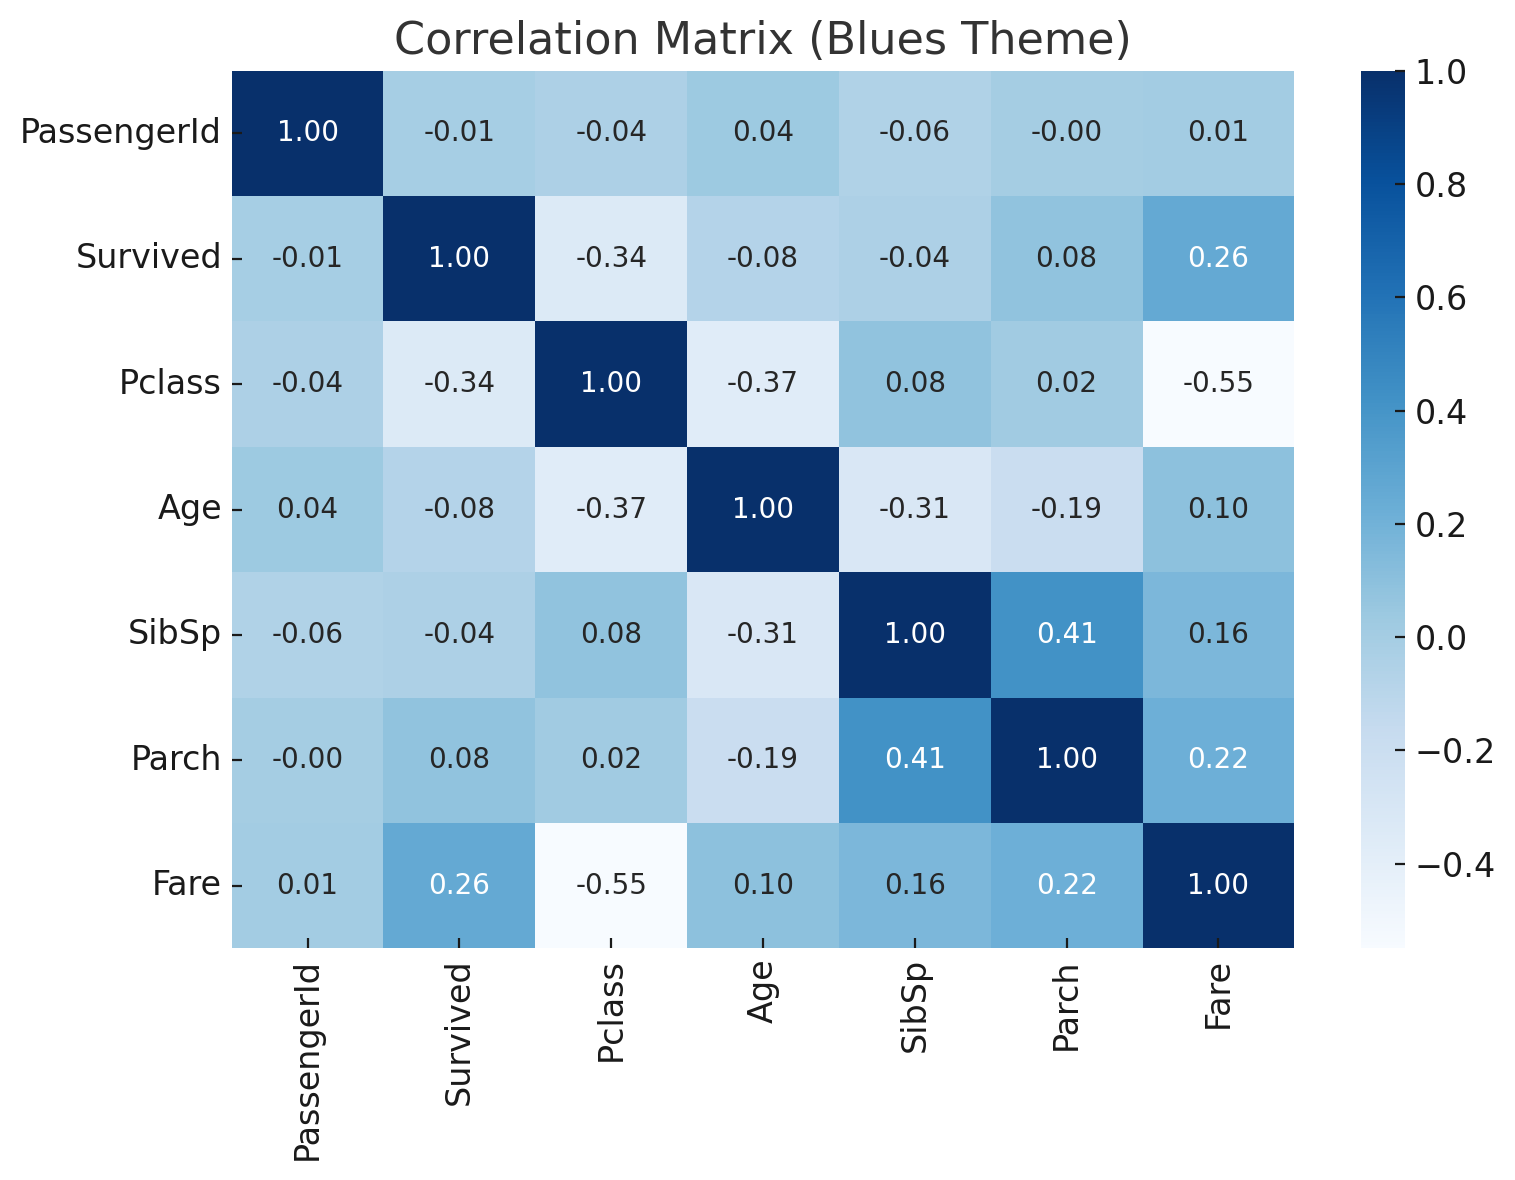

In [33]:
from IPython.display import Image, display
from pathlib import Path

file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))


## Example

In [37]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate a survival count by Gender plot and the age distribution. Use some blues colors."

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_zsa7txx0LF5VjdfixVE9XpEQ
Created message, message ID: msg_WhxHR7GmjYYtp7pQjJ4IZGbO


In [38]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_9z1eiiTB1bkLciHT9oRALo0b


In [39]:
run.usage

{'prompt_tokens': 2689, 'completion_tokens': 452, 'total_tokens': 3141, 'prompt_token_details': {'cached_tokens': 0}}

In [40]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x130d026c0>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/Azure Agent Service/NOTEBOOKS/assistant-ENT8QKQW8ShUDTgCdQLrQR_image_file.png
MessageRole.AGENT: The dataset appears to be the Titanic survivor data. To fulfill your request:

1. **Survival Count by Gender**: We'll plot counts of survivors vs. non-survivors grouped by Gender.
2. **Age Distribution**: We'll plot a histogram showing the distribution of the Age variable.

I'll use blue color gradients for these visualizations. Let's create and display the plots!
MessageRole.AGENT: Let's start by inspecting your uploaded file to identify its structure (columns, data types, sample values). This is necessary to know how to access Gender, Age, and Survival data.

I'll load and preview the data first.
MessageRole.USER: Generate a survival count by Gender plot and the age distribution. Use some blues colors.


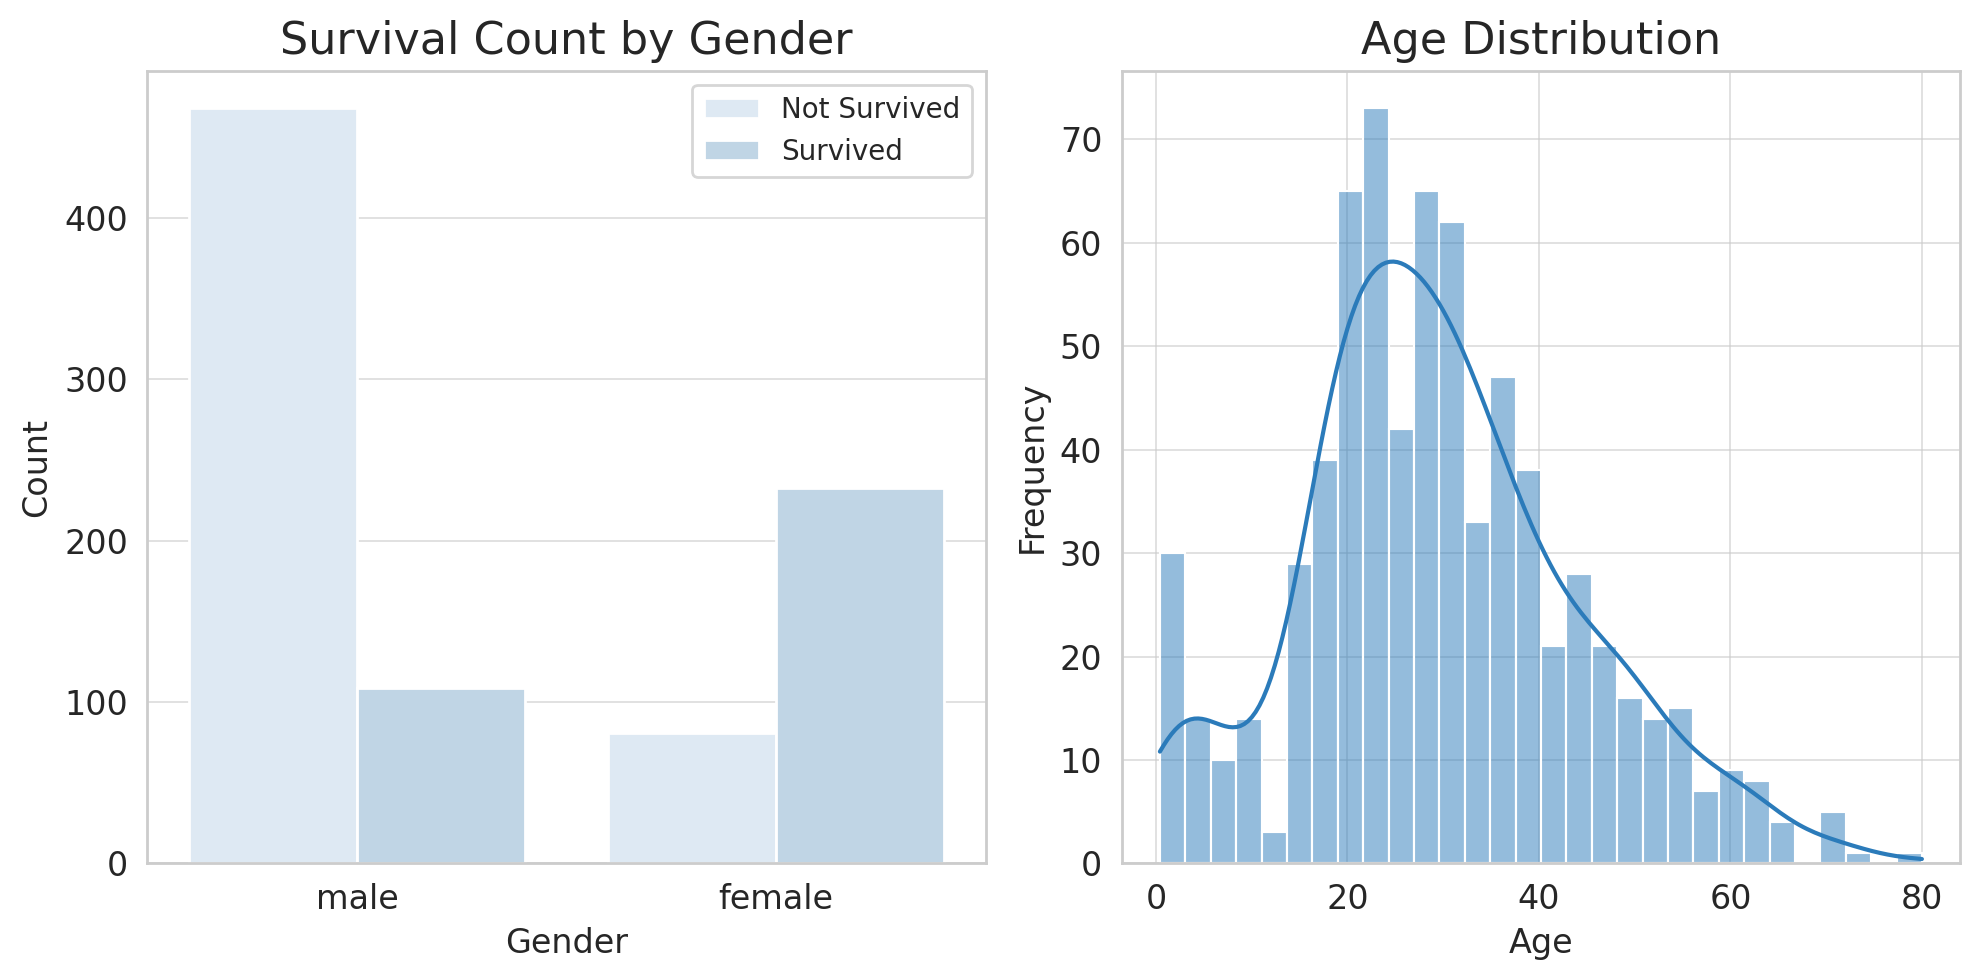

In [41]:
from IPython.display import Image, display
from pathlib import Path

file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## Example

In [42]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate a bivariate analysis of survival and pclass. Use some greens colors."

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_bPzeJRolatowM0ojPz6pgiic
Created message, message ID: msg_qO86EZ8dQi3ZSobk3xsJrsbA


In [43]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_zkCcdXxpCFpjwxPvkjvfRnG6


In [44]:
run.usage

{'prompt_tokens': 3700, 'completion_tokens': 649, 'total_tokens': 4349, 'prompt_token_details': {'cached_tokens': 0}}

In [45]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x130d02b70>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/Azure Agent Service/NOTEBOOKS/assistant-LEWkk1BriMbkYYqFeZ5Nxz_image_file.png
MessageRole.AGENT: The dataset is indeed the Titanic dataset, with 'Survived' (0 = No, 1 = Yes) and 'Pclass' (1, 2, 3) columns suitable for bivariate analysis.

Let's proceed by:

1. Creating a contingency table of Survived vs Pclass.
2. Plotting a grouped bar chart using green color tones.

Let's do this analysis!
MessageRole.AGENT: Let's first take a look at your data to understand the columns and structure, and then perform a bivariate analysis of `survival` and `pclass` (assuming it's Titanic data). The analysis will include:

1. A contingency table (cross-tabulation) of Survival by Pclass.
2. A grouped bar chart using green hues to visualize the distribution.

Let's start by inspecting the data.
MessageRole.USER: Generate a bivariate analysis of survival and pclas

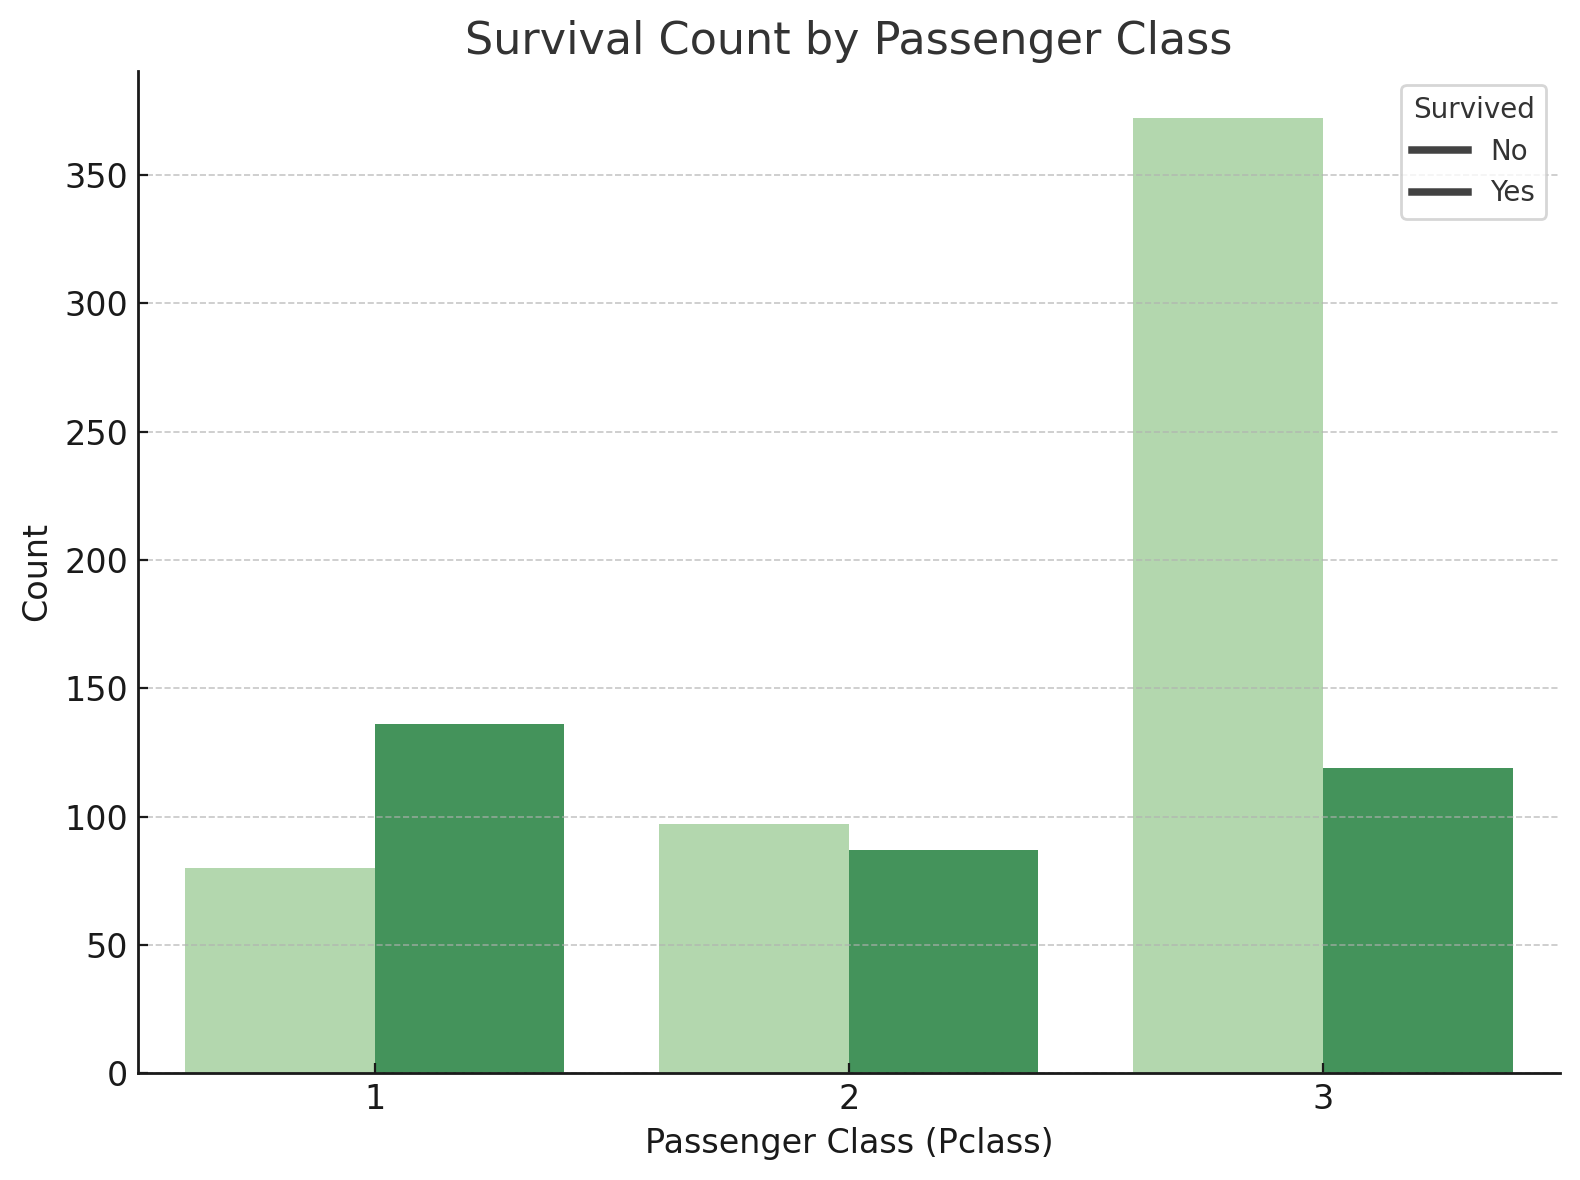

In [46]:
from IPython.display import Image, display
from pathlib import Path

file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## Example

In [48]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate a violin plot of Pclass by Age and Gender. Use lime and cyan colors."

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_8BY7X7Lf068jpYntIcqt9JXm
Created message, message ID: msg_PdU0K1LbbszOtRETW2yEyapU


In [ ]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

run.usage

Created run, run ID: run_oU1vw9oxQLzE3VmNyB8AJLbL



{'prompt_tokens': 3181, 'completion_tokens': 457, 'total_tokens': 3638, 'prompt_token_details': {'cached_tokens': 0}}

In [50]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x13042b3f0>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/Azure Agent Service/NOTEBOOKS/assistant-CzHE1SKkAoRHdAaDSTQtjB_image_file.png
MessageRole.AGENT: The dataset is a Titanic passenger data file. The relevant columns are:

- **Pclass** (passenger class)
- **Age** (age of the passenger)
- **Sex** (gender: 'male' or 'female')

Let's proceed to create a violin plot of Age by Pclass, with color split by Gender (Sex), using lime (for one gender) and cyan (for the other).
MessageRole.AGENT: To generate the requested violin plot, I'll follow these steps:

1. Load and inspect the dataset you uploaded.
2. Prepare the data for plotting (making sure columns Pclass, Age, and Gender exist and are formatted correctly).
3. Create the violin plot of Age by Pclass, with colors representing Gender, using "lime" and "cyan."

Let's start by reading and inspecting your file.
MessageRole.USER: Generate a violin plot of

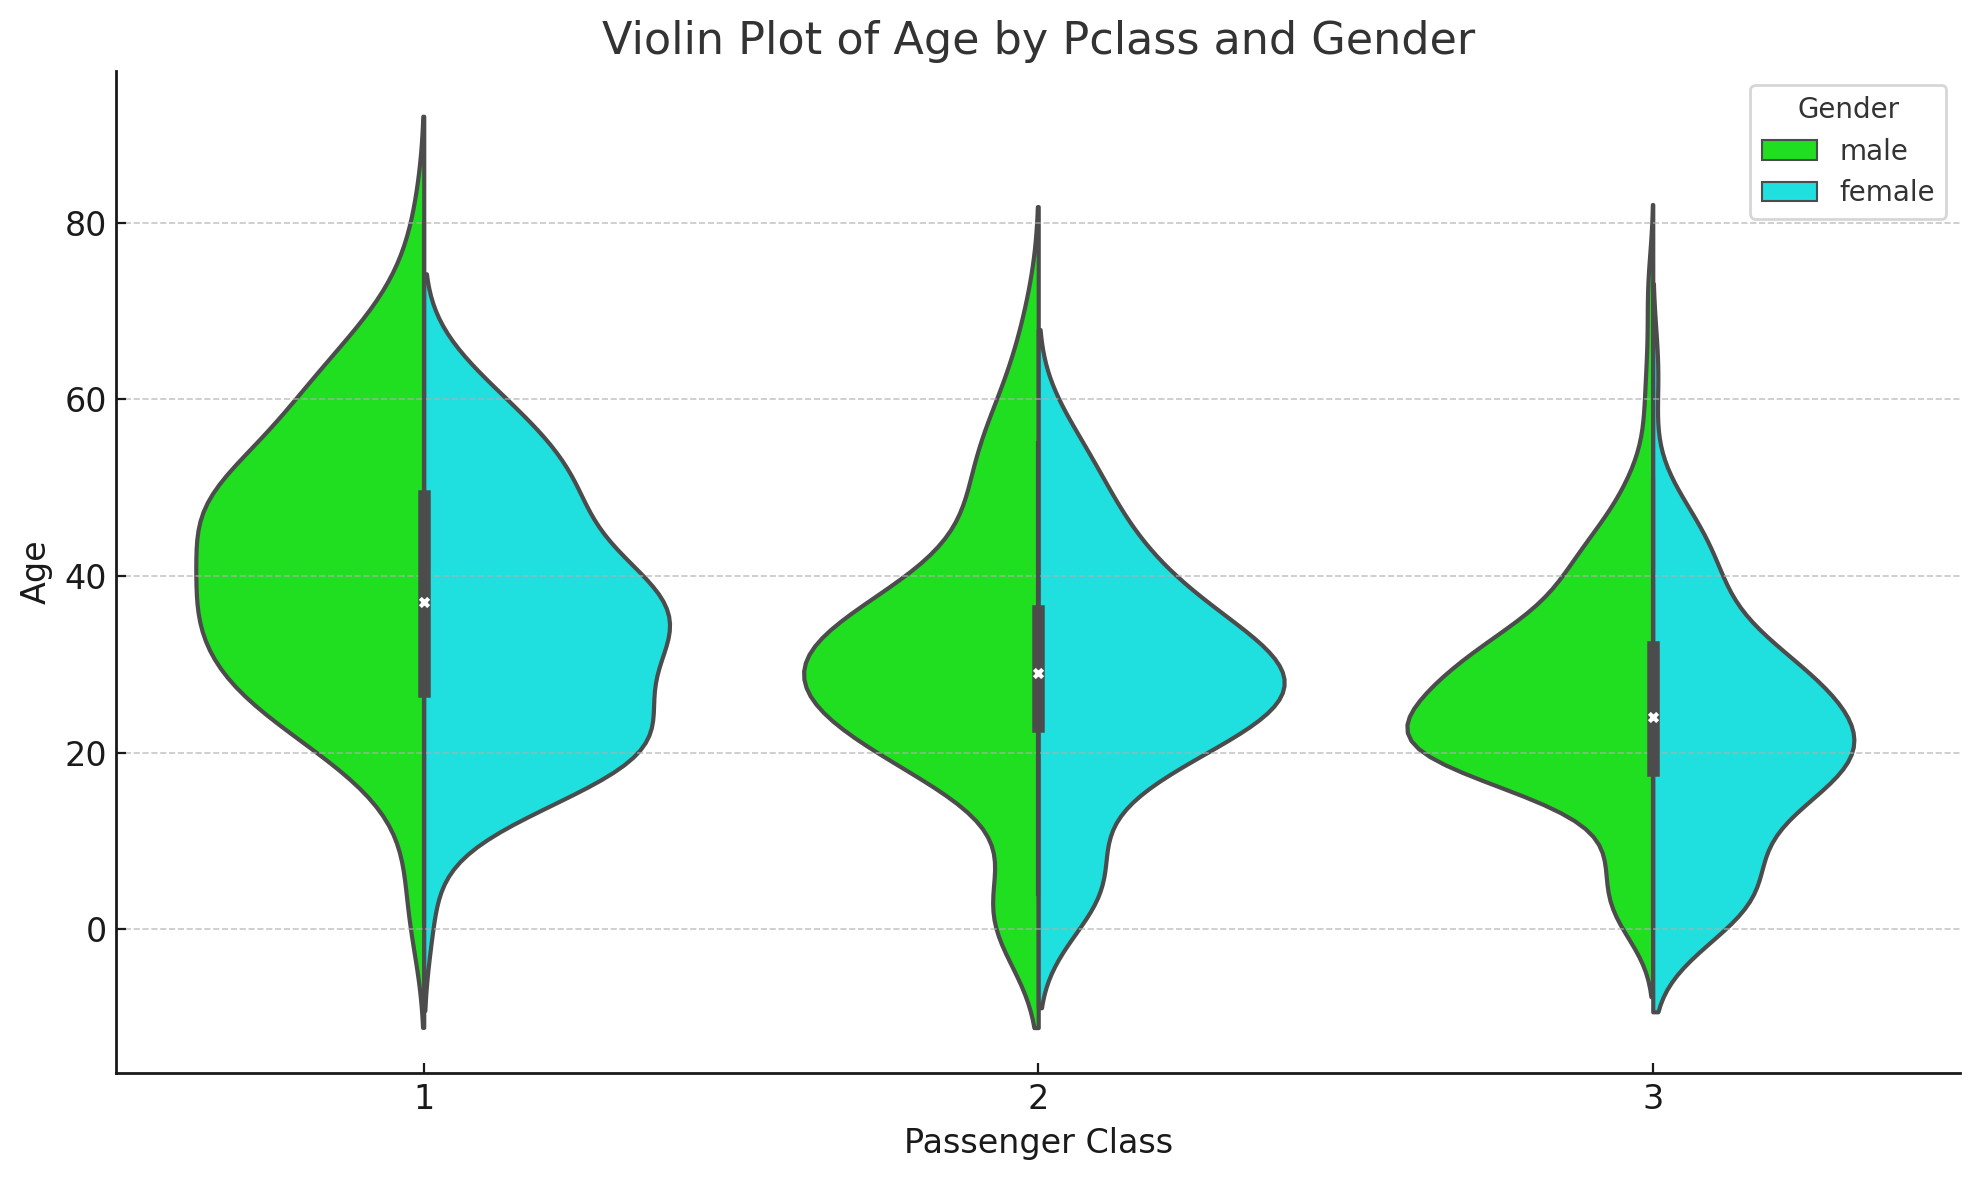

In [51]:
from IPython.display import Image, display
from pathlib import Path

file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## Example

In [52]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate the age distribution. Use lightblue color"

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_3rp4Iy1jAk6J0B3zBLDkRkhl
Created message, message ID: msg_GrQbxEFrzsuTrHdlM2v3TuSe


In [53]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

run.usage

Created run, run ID: run_IhbZaWVlDPnsqitSaggYugH1


{'prompt_tokens': 2632, 'completion_tokens': 268, 'total_tokens': 2900, 'prompt_token_details': {'cached_tokens': 0}}

In [54]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x13042baf0>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/Azure Agent Service/NOTEBOOKS/assistant-4Lx6phiw2aWs9CLqcjscde_image_file.png
MessageRole.AGENT: The dataset contains an "Age" column. I'll create the age distribution plot using a light blue color.
MessageRole.AGENT: Let's start by inspecting the file to identify the relevant columns and structure. Then, I'll generate the age distribution plot using a light blue color.
MessageRole.USER: Generate the age distribution. Use lightblue color


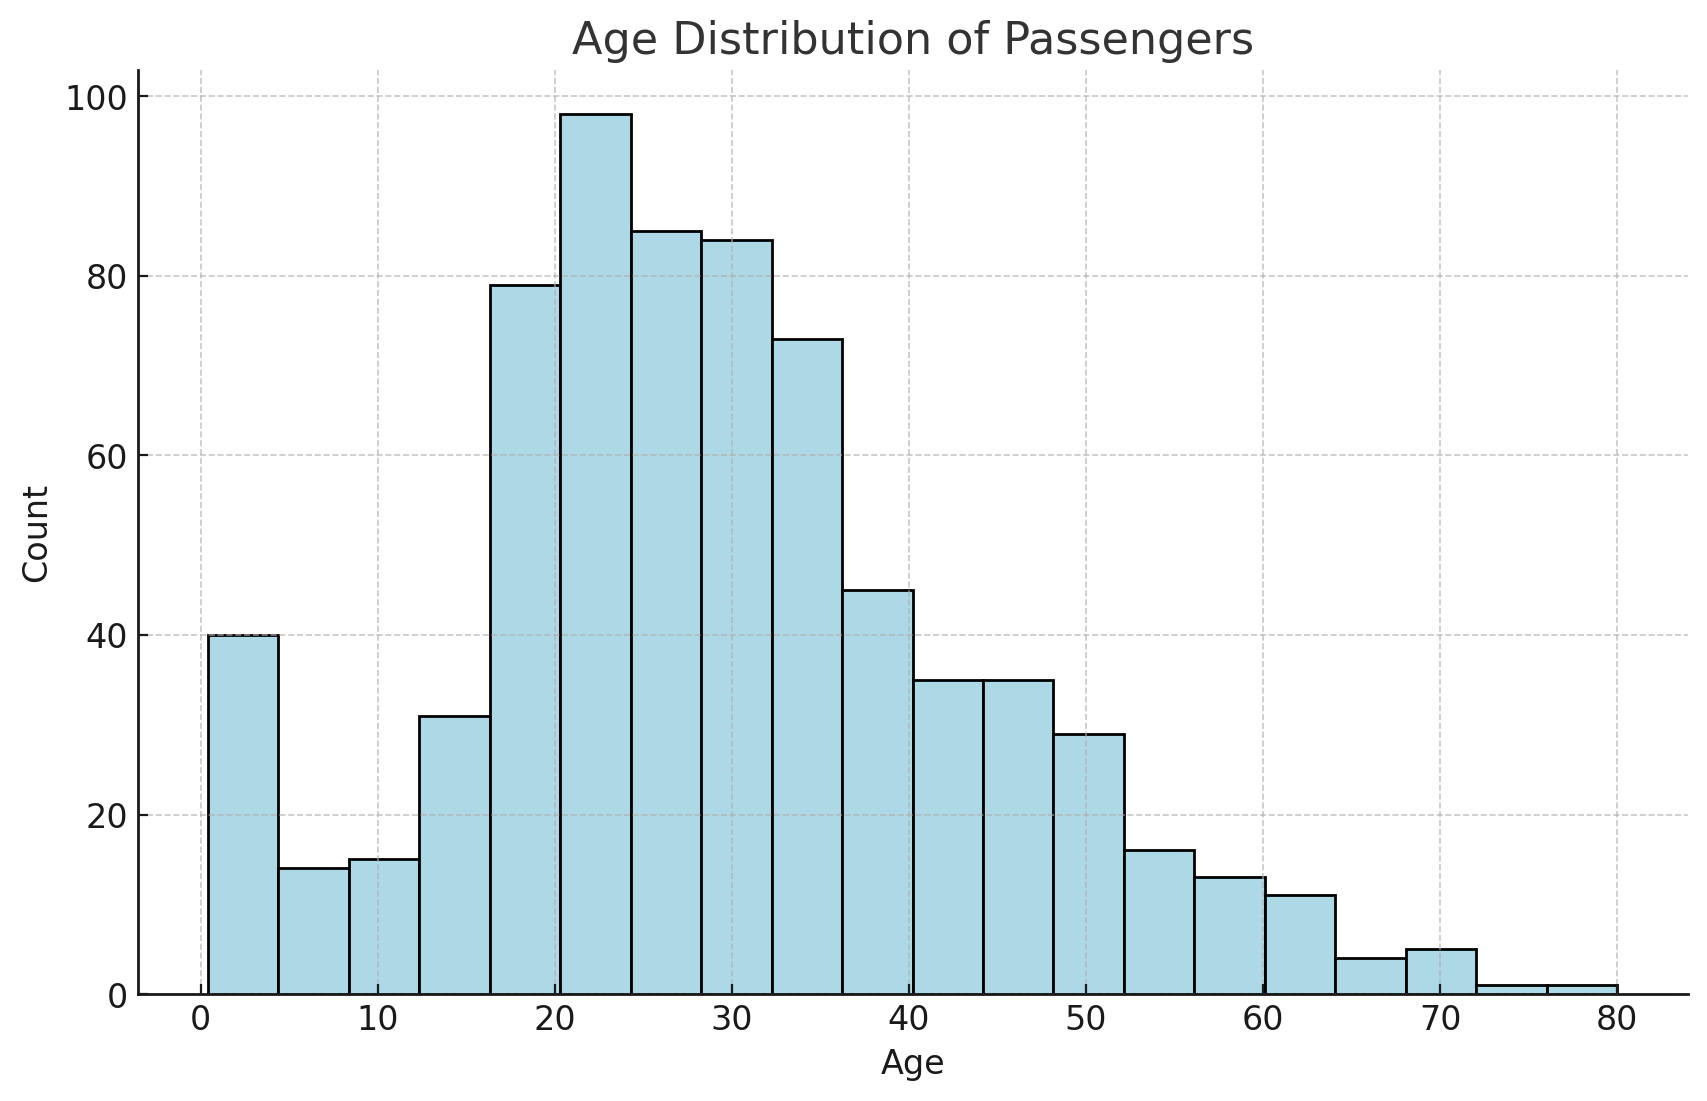

In [55]:
from IPython.display import Image, display
from pathlib import Path

file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## All images

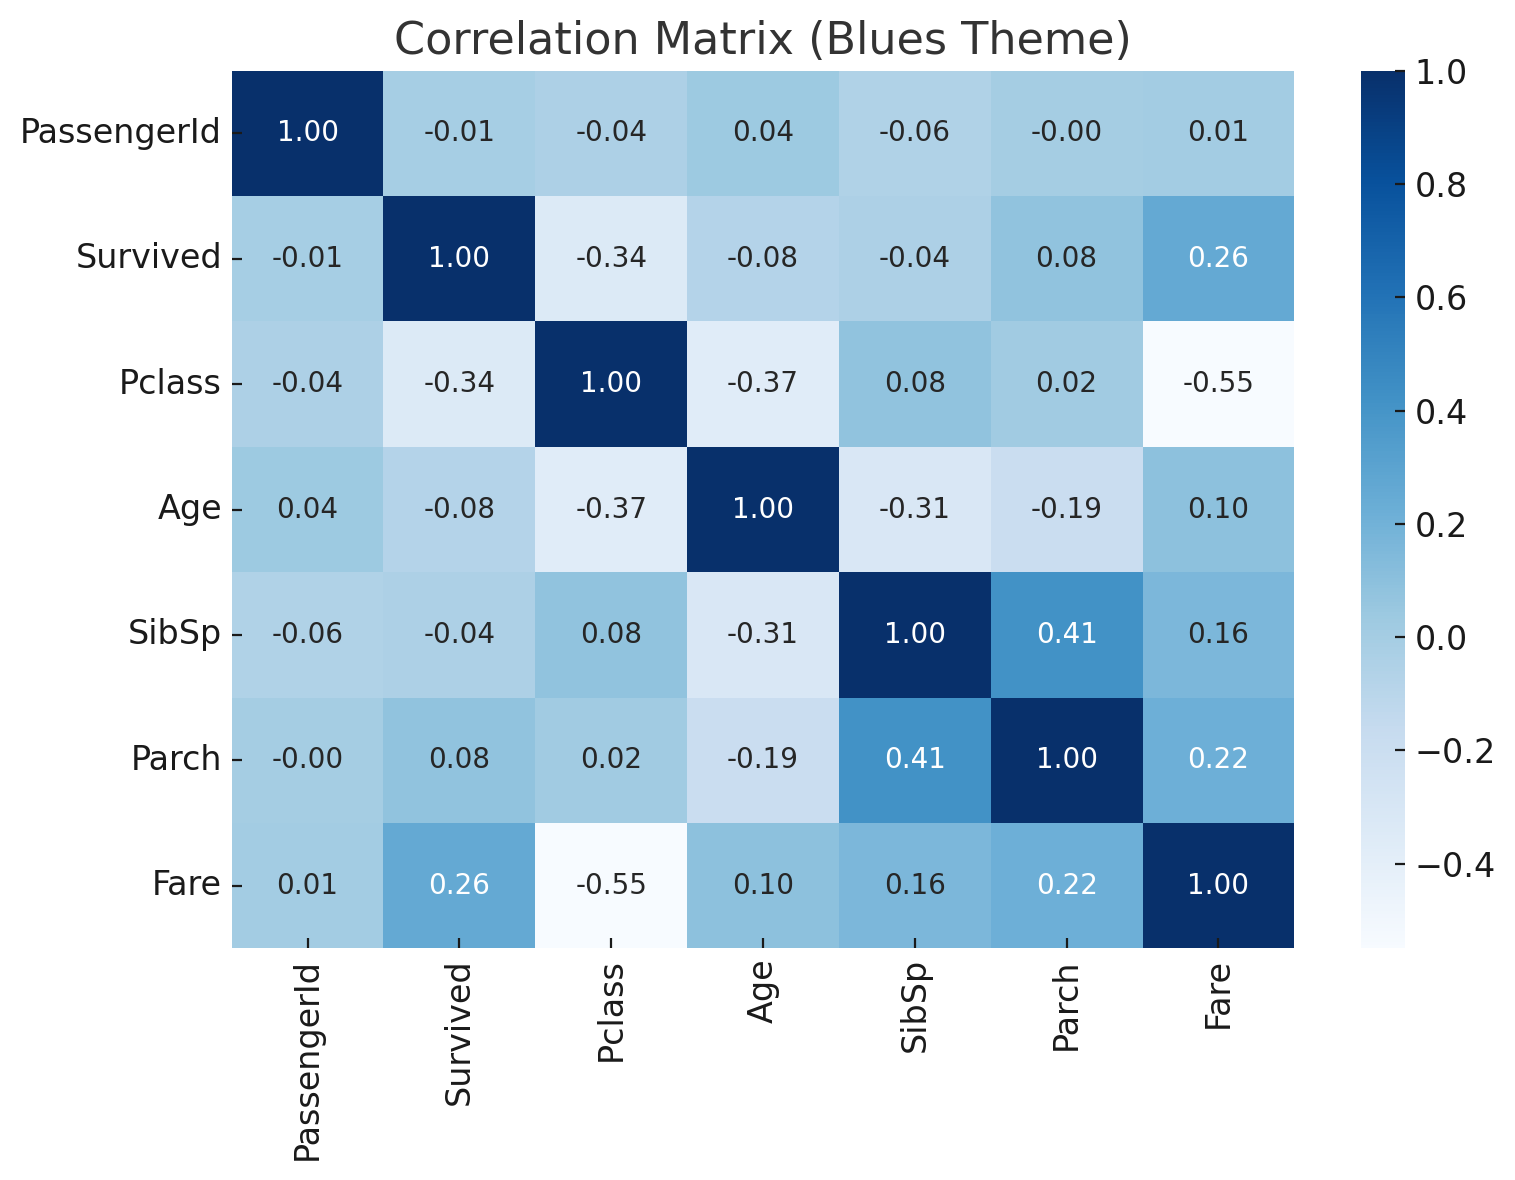

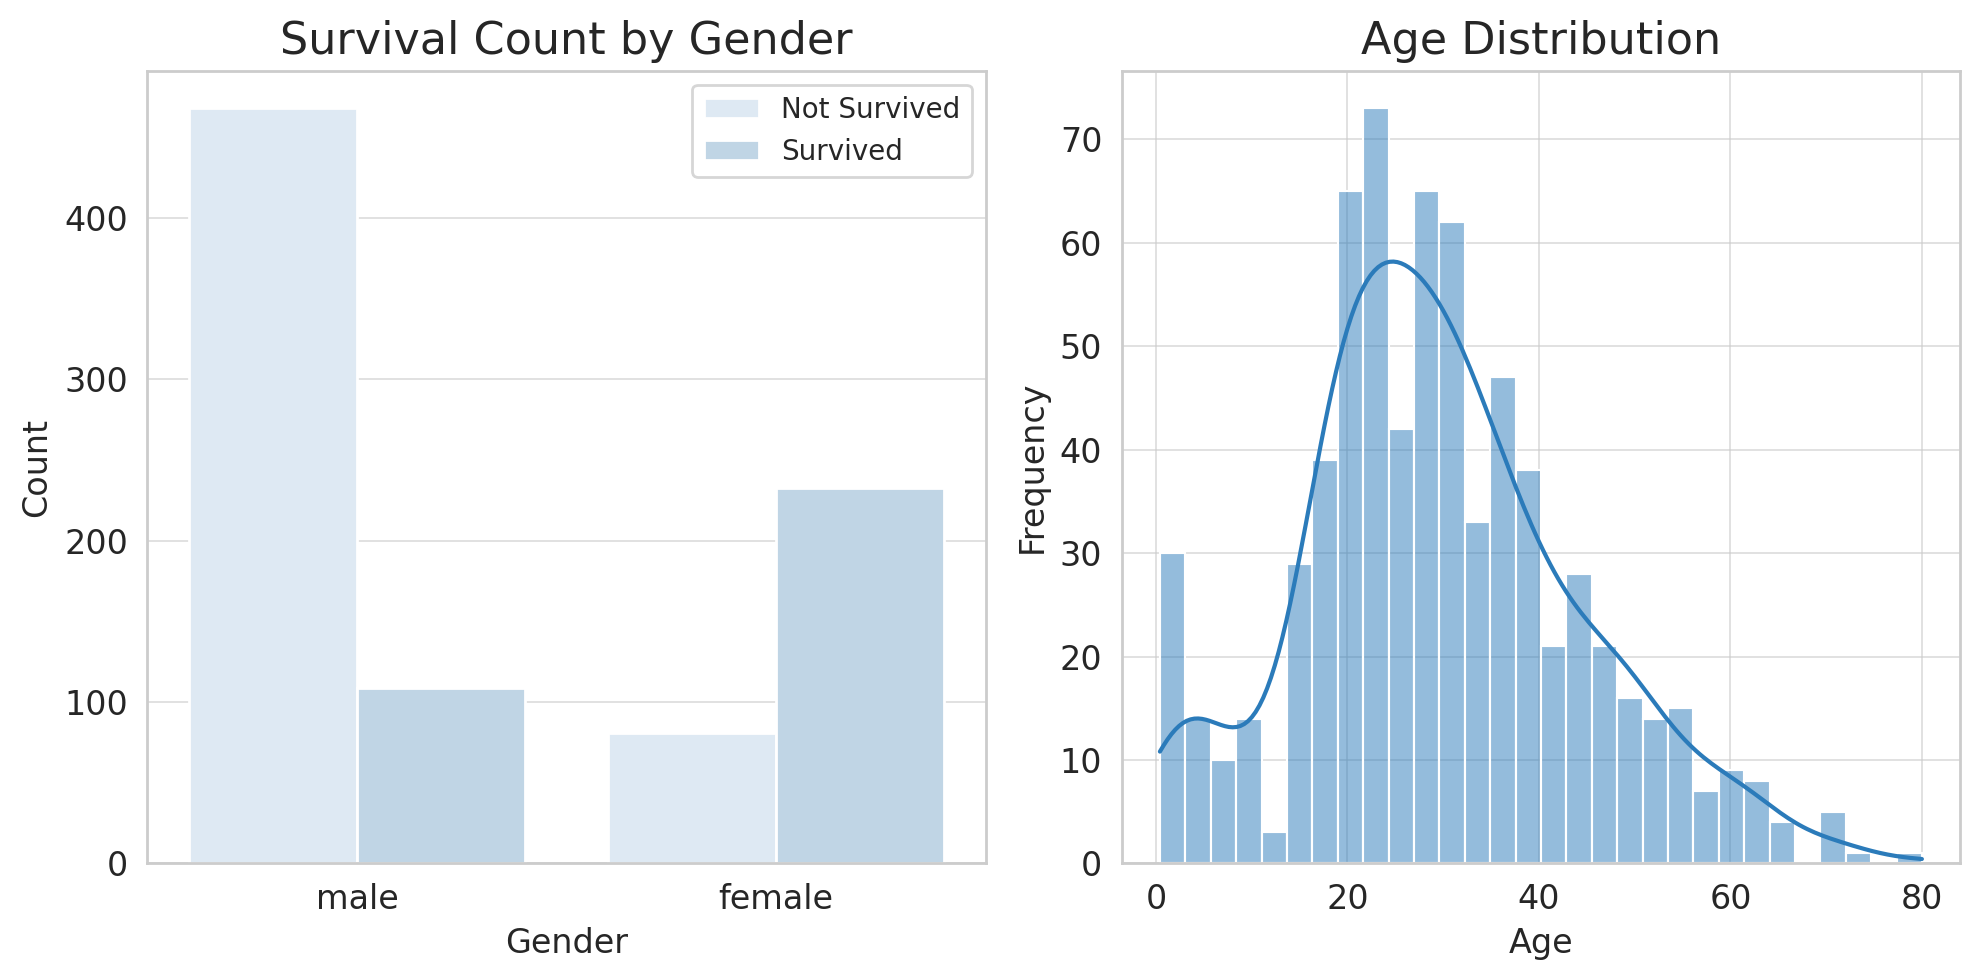

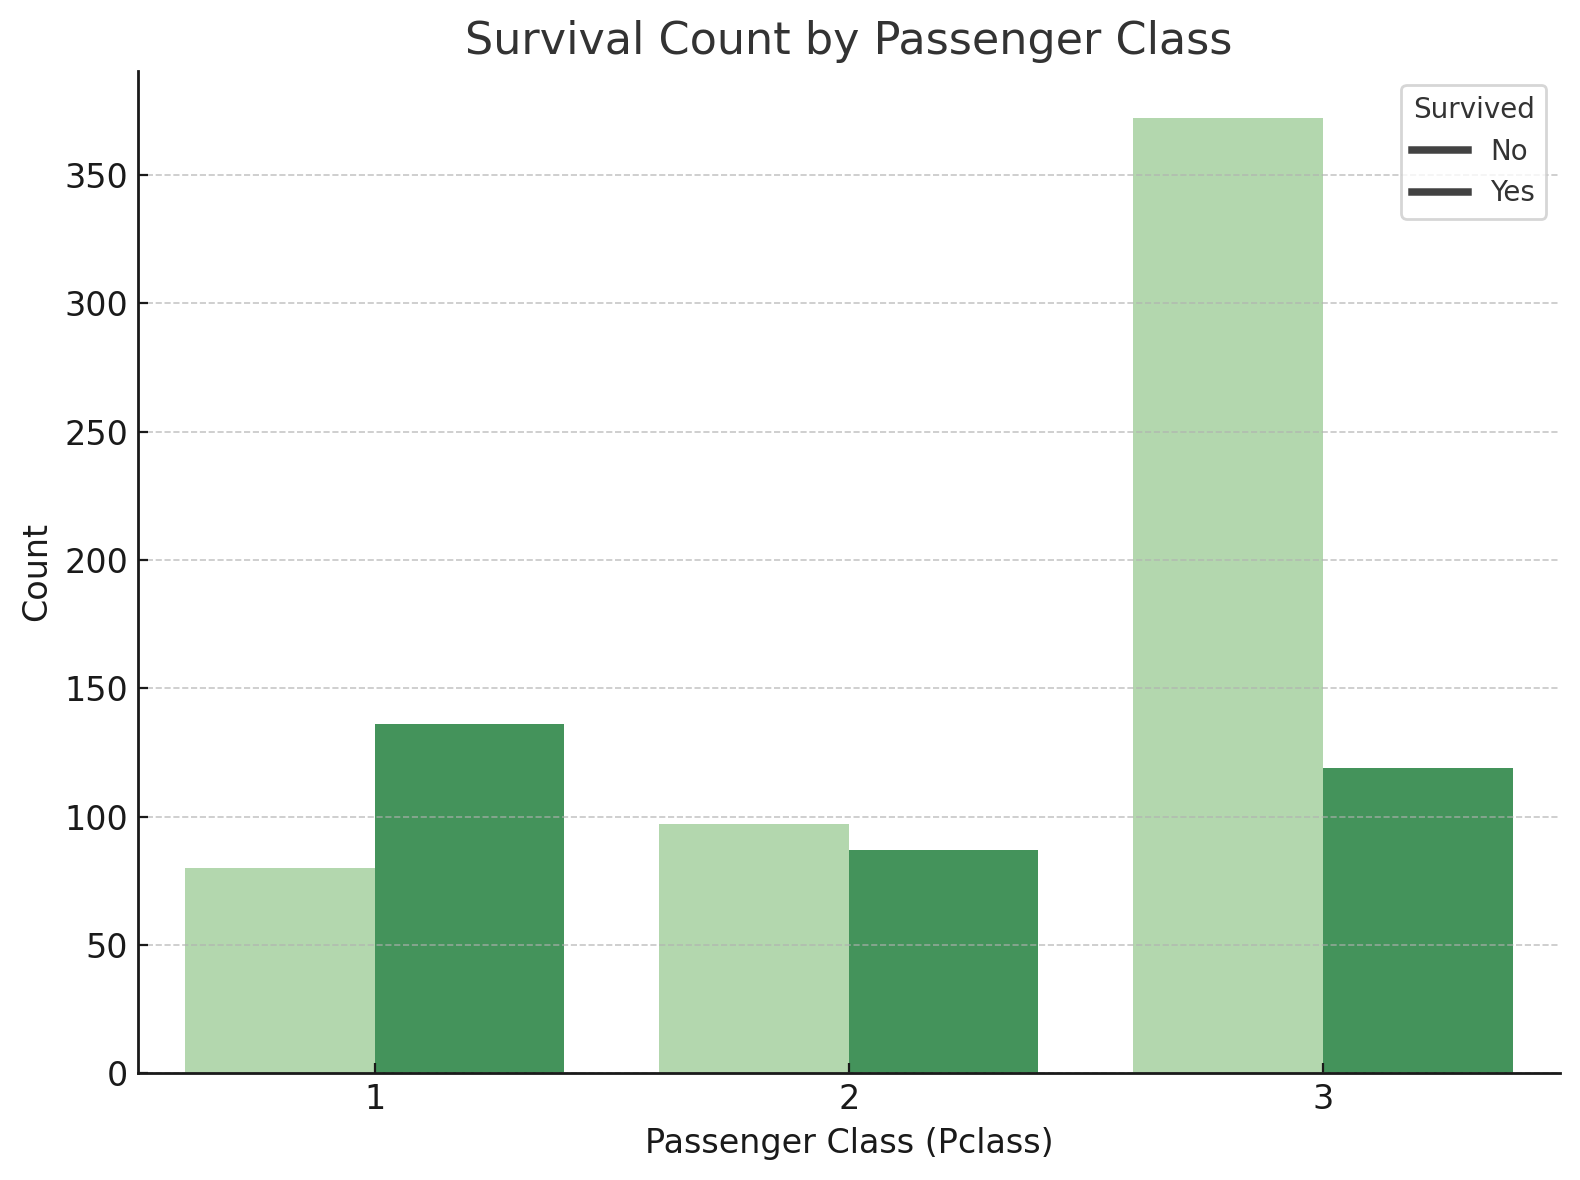

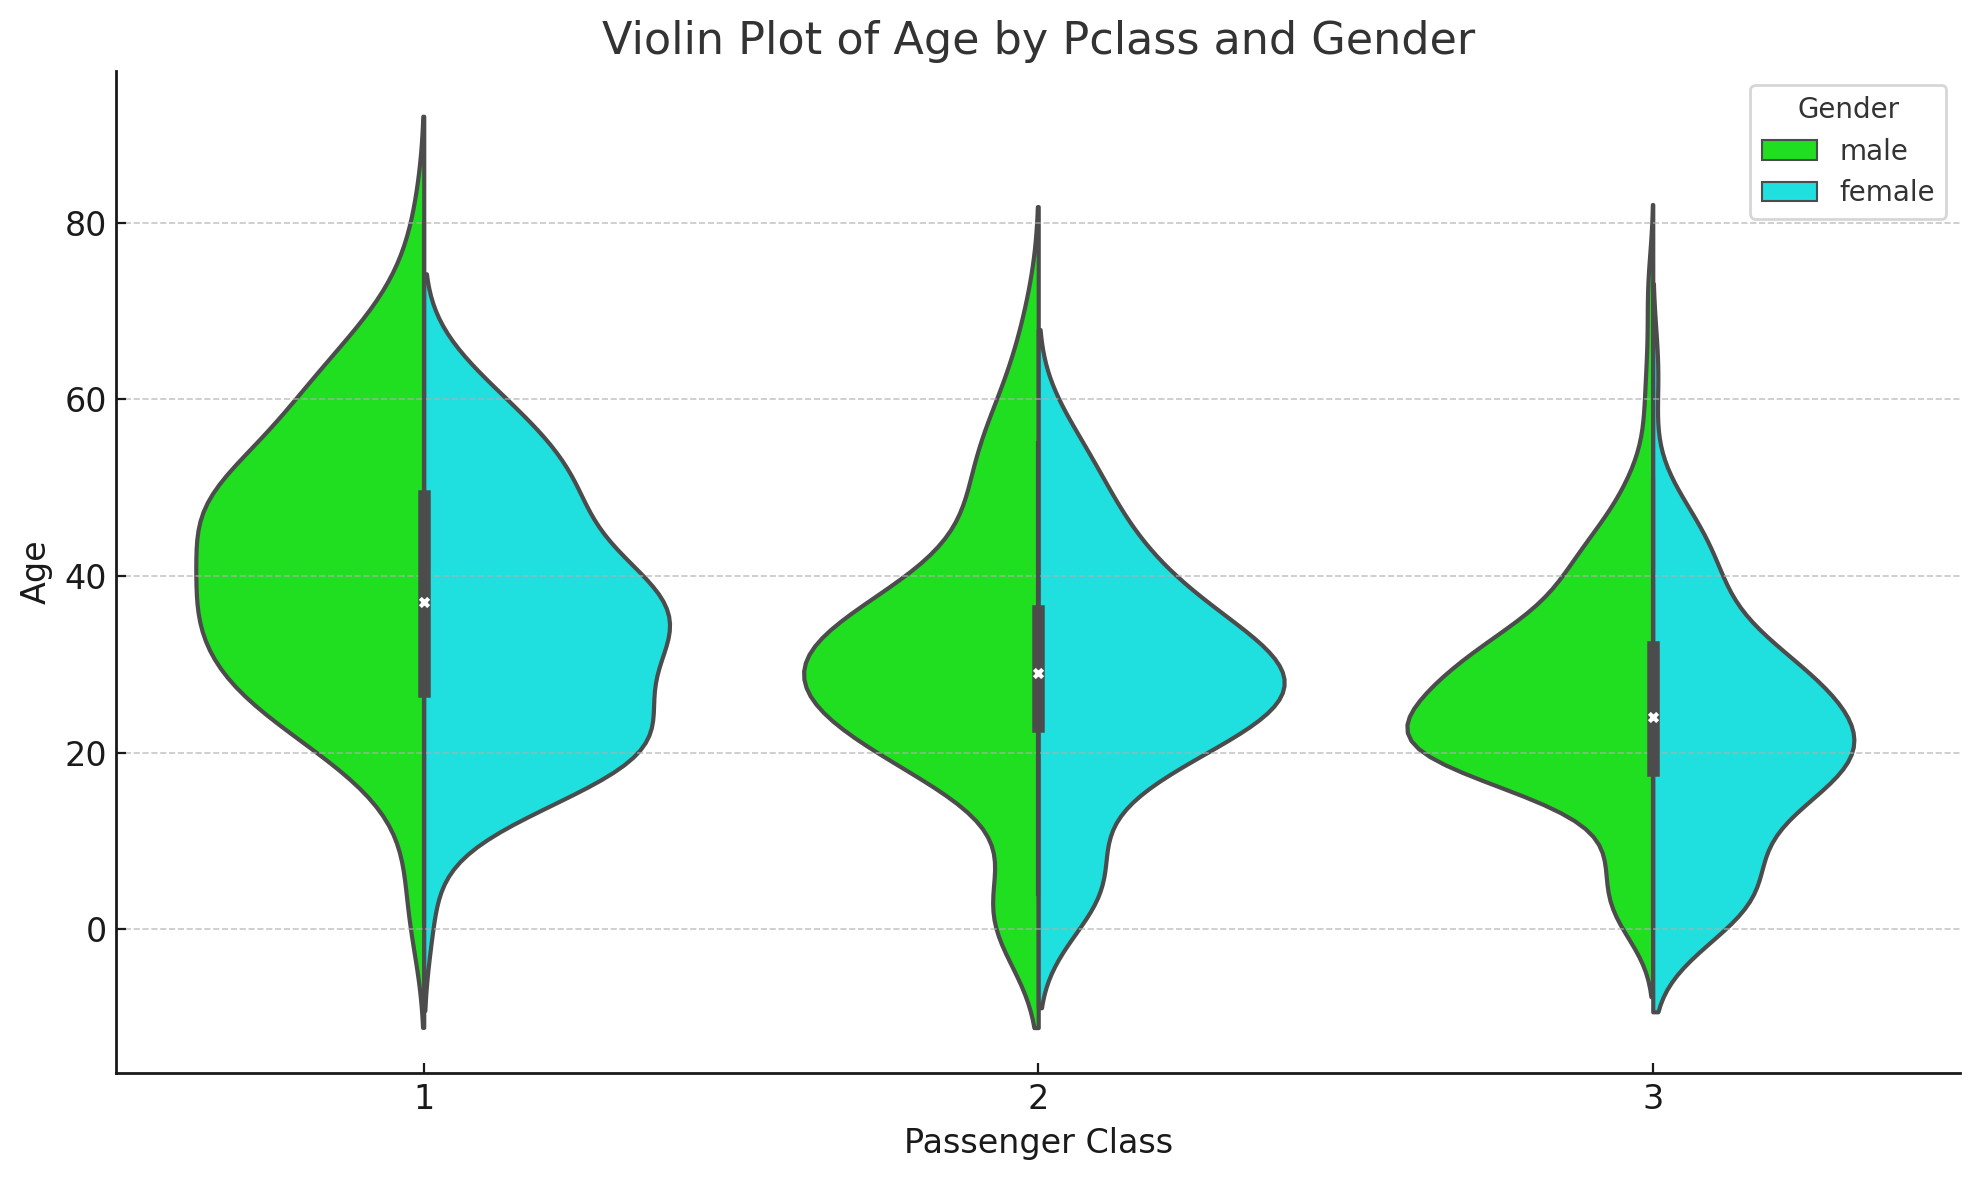

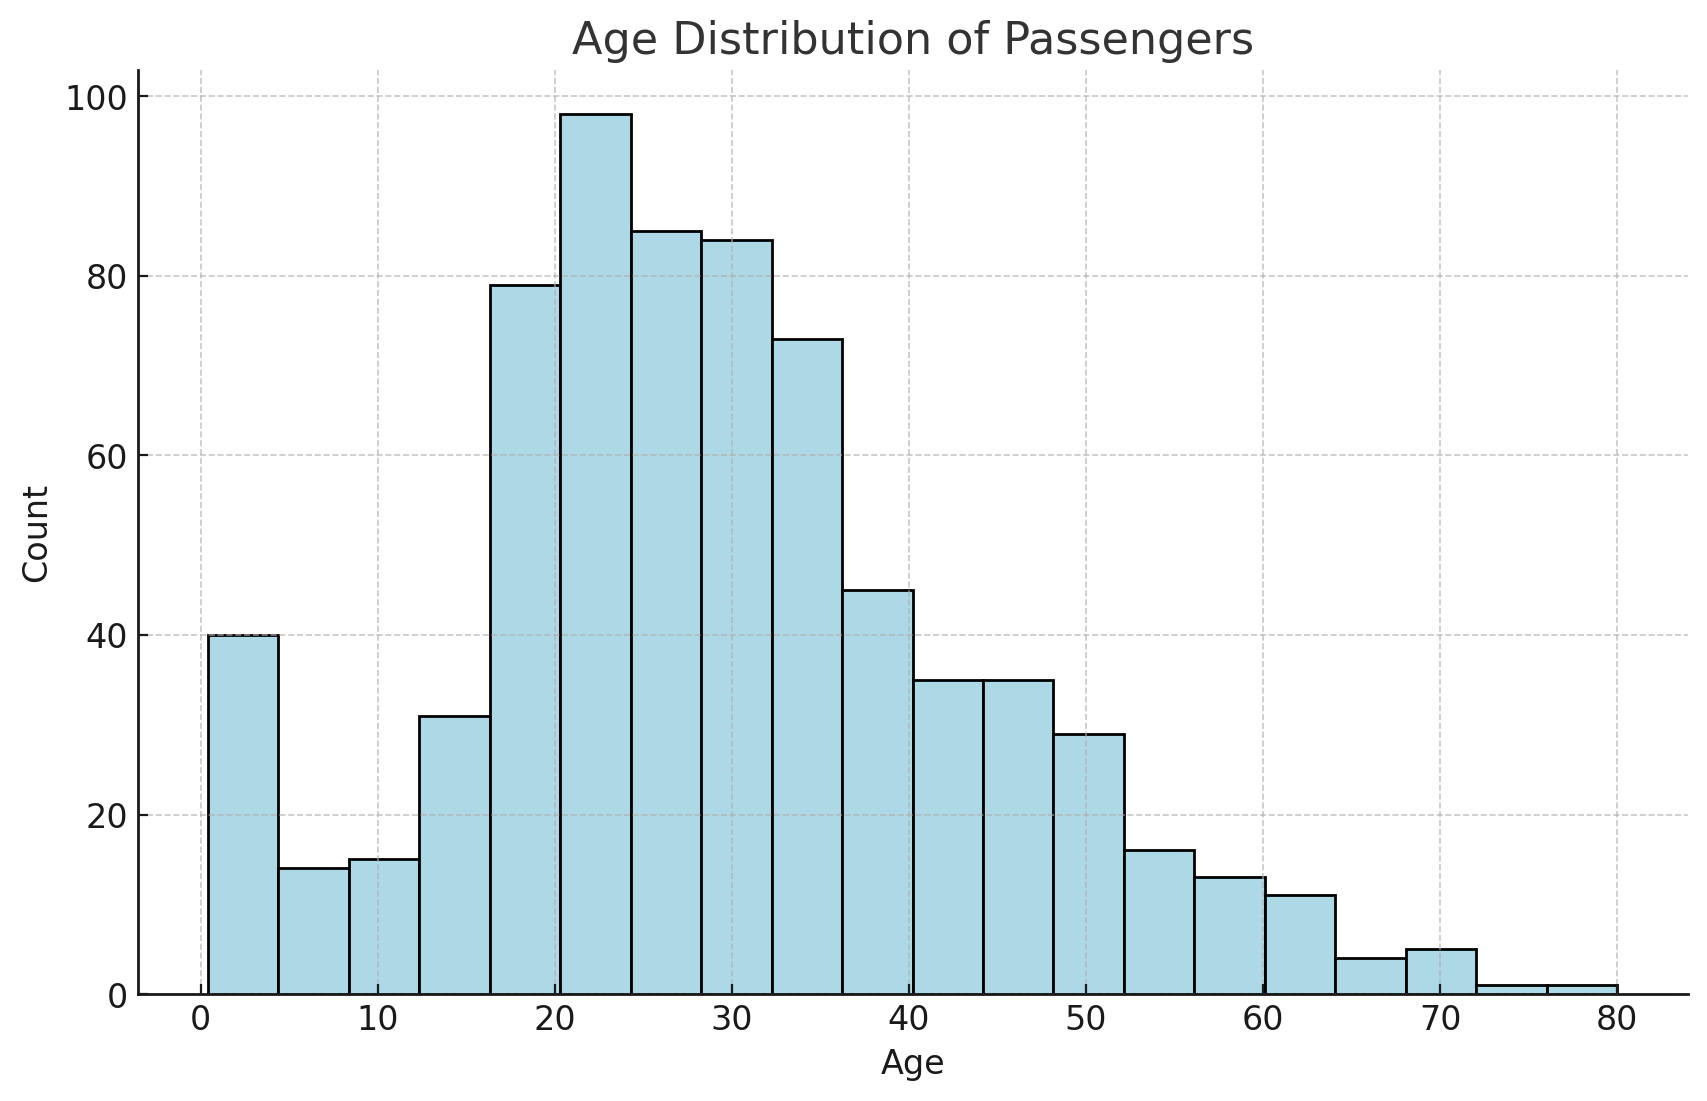

In [62]:
from IPython.display import display, Image
from pathlib import Path

# Define the directory to search for images (current working directory)
image_dir = Path.cwd()

# Find all files matching the pattern 'assistant-*.png'
image_files = sorted(
    [f for f in image_dir.glob('assistant-*.png')],
    key=lambda x: x.stat().st_mtime
)

if image_files:
    for img_path in image_files:
        display(Image(filename=str(img_path)))
else:
    print('No assistant-*.png files found in the current directory.')

## Cleaning

In [65]:
project_client.delete_agent(agent.id)
print(f"Deleted agent, agent ID: {agent.id}")

ResourceNotFoundError: (None) No assistant found with id 'asst_0DdpSEyW0m3xlzX89QX71VBG'.
Code: None
Message: No assistant found with id 'asst_0DdpSEyW0m3xlzX89QX71VBG'.